In [83]:
# general
import os
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# umap
import umap
from sklearn.manifold import trustworthiness
from scipy.spatial.distance import pdist, squareform

# clustering
from sklearn.utils import shuffle


___

### Start Timer

In [84]:
# track runtime
start = time.time()

___

### Pathing

In [85]:
# define path
nb_path = Path(os.getcwd())
print(nb_path)
path = str(nb_path.parent)
print(path)

# path to figs folder
figs_path = path + '/figs'

# path to data
data_path= path + '/data'

# path to src folder
src_path = path + '/src'
print(src_path)

# sys path
sys.path.append(src_path)

/Users/mikey/LocalFiles/DS5230/final_project/DS5230-final/notebooks
/Users/mikey/LocalFiles/DS5230/final_project/DS5230-final
/Users/mikey/LocalFiles/DS5230/final_project/DS5230-final/src


___

### Import Util Modules

In [86]:
from cluster_utils import *
from preprocessing_eda_utils import missingness_cols
from preprocessing_eda_utils import column_dtypes

____

### Parameters

In [ ]:
# design matrix csv file name
design_matrix_file_name = "/curated/beans_design.csv"

# target vector csv file name
target_file = "/curated/beans_target.csv"

# loc for shuffled design dataframe csv
shuffled_design_filename = "/curated/shuffled_design.csv"

# loc for shuffled target dataframe csv
shuffled_target_filename = "/curated/shuffled_target.csv"

# missingness threshold for determining columns to drop
missingness_threshold = 0.20

# min frequency for nomical transformer; OneHotEncoder
min_frequency = 20

# number of dimensions for latent manifold
n_components = 2

____

## Define Functions

### UMAP

In [87]:
def umap_dim_red(cap_x):
    ''' 
    Description:
    Params:
    Returns:
    '''
    
    # create umap object
    reducer = umap.UMAP()

    # fit and embed
    reducer.fit(cap_x)
    embedding = reducer.transform(cap_x)

    # verify results
    assert(np.all(embedding == reducer.embedding_))

    # get params
    params = reducer.get_params()

    
    # trustworthiness
    cap_x_dist = squareform(pdist(cap_x))
    cap_x_dist_embed = squareform(pdist(embedding))
    trust = trustworthiness(X=cap_x_dist, 
                             X_embedded=cap_x_dist_embed, 
                             n_neighbors=params['n_neighbors'],
                             metric=params['metric'])

    results_dict = {
    'embedding' : embedding,
    'n_neighbors' : params['n_neighbors'],
    'min_dist' : params['min_dist'],
    'metric' : params['metric'],
    'n_components': params['n_components'],
    'trustworthiness' : trust
    }

    return results_dict


#### K-means

In [88]:
def cluster_kmeans(cap_x, n_clusters, df_row_dict_list):
    '''
    Description: Performs k-means clustering.

        https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

    Input:
            cap_x: embedding (ndarray)
            n_cclusters: value for n_clusters (int)
            df_row_dict_list = list for dicts of kmeans results    
    Returns:
            df_row_dict_list.append({
                                    'n_clusters': n_clusters,
                                    'inertia': inertia,
                                    'calinski_harabasz_score': indices_dict['calinski_harabasz_score'],
                                    'davies_bouldin_score': indices_dict['davies_bouldin_score'],
                                    'silhouette_score': indices_dict['silhouette_score']
                                }
    '''
    # define kmeans object and set params
    kmeans = KMeans()

    # fit k means
    kmeans.fit_predict(cap_x)


    # get lables and inertia
    labels = kmeans.labels_
    inertia = kmeans.inertia_

    # internal indices
    indices_dict = kmeans_indices(cap_x, labels)

    # add values to dict list
    df_row_dict_list.append(
        {
            'n_clusters': n_clusters,
            'inertia': inertia,
            'calinski_harabasz_score': indices_dict['calinski_harabasz_score'],
            'davies_bouldin_score': indices_dict['davies_bouldin_score'],
            'silhouette_score': indices_dict['silhouette_score'],
            'cluster_labels': labels
        }
    )
    return df_row_dict_list

In [89]:
def kmeans(results_dict):
    ''' 
    Description:
    Params:
    Returns:
    '''
    print('*'*100)
    print('*'*100)
    print('Hyperparameters:')
    print('n_neighbors: ', results_dict['n_neighbors'])
    print('min_dist: ', results_dict['min_dist'])
    print('metric: ', results_dict['metric'])
    print('n_components: ', results_dict['n_components'])


    # set umap embedding as cap_x
    cap_x = results_dict['embedding']

    # choose a range of n_clusters to try for kmeans
    n_clusters_list = np.arange(2, 16, 1)

    # init dict
    df_row_dict_list = []

    # iterate over values of n in n_clusters_list
    for n_clusters in n_clusters_list:

        # run clusters for values of n
        # results for each iteration collected in df_row_dict_list 
        cluster_kmeans(cap_x, n_clusters, df_row_dict_list)
    
    # convert results dicts to dataframe
    results_df = pd.DataFrame(df_row_dict_list)

    # determine elbow location
    n_clusters_found = find_elbow(results_df, sensitivity=1.0)

    ## hopkins statistic
    cap_h = get_hopkins(cap_x)
    print(f"Hopkin's Statistic = {cap_h}")
    
    ## testing KMEANS using internal indicies
    n_clusters_db_score_is_min = results_df.loc[results_df['davies_bouldin_score'].idxmin(), 'n_clusters']
    n_clusters_ch_score_is_max = results_df.loc[results_df['calinski_harabasz_score'].idxmax(), 'n_clusters']
    n_clusters_silhouette_score_is_max = results_df.loc[results_df['silhouette_score'].idxmax(), 'n_clusters']
    sil_score = results_df.loc[results_df['silhouette_score'].idxmax(), 'silhouette_score']
    cluster_labels = results_df.loc[results_df['n_clusters'] == n_clusters_found, 'cluster_labels']

    # will return valid results in df_row_dict
    df_row_dict = {
        'algo': 'k_means',
        'n_clusters_found' : n_clusters_found,
        'n_clusters_db_score_is_min' : n_clusters_db_score_is_min,
        'n_clusters_ch_score_is_max' : n_clusters_ch_score_is_max,
        'n_clusters_silhouette_score_is_max' : n_clusters_silhouette_score_is_max,
        'silhouette_score' : sil_score,
        'hopkins_statistic' : cap_h,
        'umap_n_neighbors' : results_dict['n_neighbors'],
        'umap_min_dist' : results_dict['min_dist'],
        'umap_metric' : results_dict['metric'],
        'umap_n_components' : results_dict['n_components'],
        'trustworthiness' : results_dict['trustworthiness'],
        'eps' : np.nan,
        'dbscan_min_samples' : np.nan,
        'validity_index' : np.nan,
        'cluster_labels': cluster_labels,
        'embedding' : cap_x
        }
    
    # test1
    if n_clusters_found == n_clusters_db_score_is_min == n_clusters_ch_score_is_max == n_clusters_silhouette_score_is_max:
        print("Test1 Pass: Kmeans successfully clustered.")
        print('Number of Clusters: ', n_clusters_found)
        return df_row_dict, True
    # test2
    if  n_clusters_db_score_is_min == n_clusters_ch_score_is_max == n_clusters_silhouette_score_is_max:
        print("Test2 Pass: Kmeans successfully clustered.")
        print('Number of Clusters: ', n_clusters_found)
        return df_row_dict, True
    else:
        print("Fail: Kmeans did not successfully cluster.")
        return df_row_dict, False

### DBSCAN

In [90]:
def dbscan(results_dict):
    ''' 
    Description:
    Params:
    Returns:
    '''
    
    # set umap embedding as cap_x
    cap_x = results_dict['embedding']

    # get eps and min_samples from knee locator
    eps, min_samples = find_eps(cap_x)

    # iterate over a range near eps to find best eps value, determined by valididty score
    eps_scan_range = [0.8, 1.8, 0.1]
    f_eps_list = factor_eps(eps, eps_scan_range)
    
    # iterate dbscan over the eps values in f_eps_list
    results_df = cluster_dbscan(cap_x, f_eps_list, min_samples)
    
    # get values where validy score is greatest
    validity_index = results_df.loc[results_df['validity_index'].idxmax(), 'validity_index']
    eps = results_df.loc[results_df['validity_index'].idxmax(), 'k_dist_eps']
    min_samples = results_df.loc[results_df['validity_index'].idxmax(), 'min_samples']
    n_clusters_found = results_df.loc[results_df['validity_index'].idxmax(), 'n_clusters']
    cluster_label = results_df.loc[results_df['validity_index'].idxmax(), 'cluster_labels']

    print('DBSCAN')
    print('Number of Clusters: ', n_clusters_found)
    print('Validity Index: ', validity_index)

    # return results in df_row_dict
    df_row_dict = {
            'algo': 'dbscan',
            'n_clusters_found' : n_clusters_found,
            'n_clusters_db_score_is_min' : np.nan,
            'n_clusters_ch_score_is_max' : np.nan,
            'n_clusters_silhouette_score_is_max' : np.nan,
            'silhouette_score' : np.nan,
            'hopkins_statistic' : results_dict['hopkins_statistic'],
            'umap_n_neighbors' : results_dict['umap_n_neighbors'],
            'umap_min_dist' : results_dict['umap_min_dist'],
            'umap_metric' : results_dict['umap_metric'],
            'umap_n_components' : results_dict['umap_n_components'],
            'trustworthiness' : results_dict['trustworthiness'],
            'eps' : eps,
            'dbscan_min_samples' : min_samples,
            'validity_index' : validity_index,
            'cluster_labels': [cluster_label]
            }


    return df_row_dict

# Pipeline

____

## Load Data

In [92]:
# read in design matrix dataframe
design_df  = pd.read_csv( data_path + design_matrix_file_name )

# read in encoded target vector dataframe
target_vector = pd.read_csv( data_path + target_file, index_col=0)

___

## Get Machine Learning Attributes

___

### Identify Columns with Missing Value Count Above Threshold

In [93]:
# check columns for missingness
missingness_drop_list = missingness_cols(design_df, missingness_threshold)

# display results
if missingness_drop_list == []:
    print(f'There are no columns that require dropping based on missingness')
else:
    print(f'The following columns have a missingness proportion greater than {missingness_threshold}.')
    print(f'These columns should be dropped:')
    for i in range(len(missingness_drop_list)):
        print(f'\t{i + 1}. {missingness_drop_list[i]}')

There are no columns that require dropping based on missingness


___

### Visually Inspect Design Matrix:

In [94]:
design_df.head(10)

,Unnamed: 0,id,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,0,0,28395.0,610.291,208.178117,173.888747,1.197191,0.549812,28715.0,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724
1,1,1,28734.0,638.018,200.524796,182.734419,1.097356,0.411785,29172.0,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430
2,2,2,29380.0,624.110,212.826130,175.931143,1.209713,0.562727,29690.0,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066
3,3,3,30008.0,645.884,210.557999,182.516516,1.153638,0.498616,30724.0,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199
4,4,4,30140.0,620.134,201.847882,190.279279,1.060798,0.333680,30417.0,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166
5,5,5,30279.0,634.927,212.560556,181.510182,1.171067,0.520401,30600.0,196.347702,0.775688,0.989510,0.943852,0.923726,0.007020,0.003153,0.853270,0.999236
6,6,6,30477.0,670.033,211.050155,184.039050,1.146768,0.489478,30970.0,196.988633,0.762402,0.984081,0.853080,0.933374,0.006925,0.003242,0.871186,0.999049
7,7,7,30519.0,629.727,212.996755,182.737204,1.165591,0.513760,30847.0,197.124320,0.770682,0.989367,0.967109,0.925480,0.006979,0.003158,0.856514,0.998345
8,8,8,30685.0,635.681,213.534145,183.157146,1.165852,0.514081,31044.0,197.659696,0.771561,0.988436,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953
9,9,9,30834.0,631.934,217.227813,180.897469,1.200834,0.553642,31120.0,198.139012,0.783683,0.990810,0.970278,0.912125,0.007045,0.003008,0.831973,0.999061


___

### Identify Feature Types: Nominal & Numerical

In [95]:
# get nominal and numerical columns, print column dtype
nominal_cols, numerical_cols, unique_value_cols = column_dtypes(design_df)

# display nominal cols
if nominal_cols == []:
    print(f'There no nominal columns in the dataset.\n')
else:
    print(f'The nominal columns are:')
    for i in range(len(nominal_cols)):
        print(f'{i + 1}: {nominal_cols[i]}')

# display numerical cols
if numerical_cols == []:
    print(f'There no numerical columns in the dataset.')
else:
    print(f'The {len(numerical_cols)} numerical columns are:')
    for i in range(len(numerical_cols)):
        print(f'\t{i + 1}: {numerical_cols[i]}')

# display unique values information
if unique_value_cols == []:
    print(f'\nThere no columns with all unique values in the dataset.')
else:
    print(f'\nThe {len(unique_value_cols)} columns with all unique values are:')
    for i in range(len(unique_value_cols)):
        print(f'\t{i + 1}: {unique_value_cols[i]}')

Column: Unnamed: 0
Data Type: int64
Unique value count: 13611, DF length: 13611, Ratio: 1.0
***
FLAG column Unnamed: 0 for review 
***
__________________________________________________________

Column: id
Data Type: int64
Unique value count: 13611, DF length: 13611, Ratio: 1.0
***
FLAG column id for review 
***
__________________________________________________________

Column: Area
Data Type: float64
Unique value count: 12011, DF length: 13611, Ratio: 0.88
__________________________________________________________

Column: Perimeter
Data Type: float64
Unique value count: 13413, DF length: 13611, Ratio: 0.99
__________________________________________________________

Column: MajorAxisLength
Data Type: float64
Unique value count: 13543, DF length: 13611, Ratio: 1.0
__________________________________________________________

Column: MinorAxisLength
Data Type: float64
Unique value count: 13543, DF length: 13611, Ratio: 1.0
__________________________________________________________

Colum

___

### Create Non Machine Learning Attributes List

In [96]:
# display columns
design_df.columns

Index(['Unnamed: 0', 'id', 'Area', 'Perimeter', 'MajorAxisLength',
       'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea',
       'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness',
       'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [97]:
# attributes not to be used for machine learning
non_ml_attr_list = ['id']
for col in non_ml_attr_list:
    if col in nominal_cols:
        nominal_cols.remove(col)
    if col in numerical_cols:
        numerical_cols.remove(col)

# instaniate ml_ignore_list
ml_ignore_list = [missingness_drop_list + non_ml_attr_list]

# add any attributes that should be dropped from dataframe
drop_list = ['Unnamed: 0'] # 'Unnamed: 0' is a secondary id column and can be dropped. 

# drop cols in drop_list from design matrix
cols1 = design_df.columns
design_df.drop(drop_list, axis = 1, inplace = True)
assert(len(design_df.columns) != len(cols1))

# drop col names in drop_list from nominal and numerical lists
for col in drop_list:
    if col in nominal_cols:
        nominal_cols.remove(col)
    if col in numerical_cols:
        numerical_cols.remove(col)
assert(design_df.shape[1] == len(non_ml_attr_list) + len(numerical_cols) + len(nominal_cols))

# display finalized ML attributes information
print(f'Training X Dimensions: \n \t{design_df[numerical_cols + nominal_cols].shape}')

print('Non Machine Learning Attributes:')
for i, element in enumerate(non_ml_attr_list):
    print(f'\t {i+1}: {element}')

print('Attributes Ignored in Machine Learning:')
for i, element in enumerate(ml_ignore_list):
    print(f'\t {i+1}: {element}')

print('Numerical Columns:')
if numerical_cols == []:
    print(f'\t None')
else:
    for i, element in enumerate(numerical_cols):
        print(f'\t {i+1}: {element}')

print('Nominal Columns:')
if nominal_cols == []:
    print(f'\t None')
else:
    for i, element in enumerate(nominal_cols):
        print(f'\t {i+1}: {element}')



Training X Dimensions: 
 	(13611, 16)
Non Machine Learning Attributes:
	 1: id
Attributes Ignored in Machine Learning:
	 1: ['id']
Numerical Columns:
	 1: Area
	 2: Perimeter
	 3: MajorAxisLength
	 4: MinorAxisLength
	 5: AspectRation
	 6: Eccentricity
	 7: ConvexArea
	 8: EquivDiameter
	 9: Extent
	 10: Solidity
	 11: roundness
	 12: Compactness
	 13: ShapeFactor1
	 14: ShapeFactor2
	 15: ShapeFactor3
	 16: ShapeFactor4
Nominal Columns:
	 None


#### Feature Destriptions<br> 
* ```Area``` (A) - ***float64 - Ratio*** - The area of a bean zone and the number of pixels within its boundaries.<br><br>
* ```Perimeter``` (P) - ***float64 - Ratio*** - Bean circumference is defined as the length of its border.<br><br>
* ```MajorAxisLength```(L) - ***float64 - Ratio*** - The distance between the ends of the longest line that can be drawn from a bean.<br><br>
* ```MinorAxisLength``` (l) - ***float64 - Ratio*** - The longest line that can be drawn from the bean while standing perpendicular to the main axis.<br><br>
* ```AspectRatio``` (K) - ***float64 - Ratio*** - Defines the relationship between L and l.<br><br>
* ```Eccentricity``` (Ec) - ***float64 - Ratio*** - Eccentricity of the ellipse having the same moments as the region.<br><br>
*  ```ConvexArea``` (C) - ***float64 - Ratio*** - Number of pixels in the smallest convex polygon that can contain the area of a bean seed.<br><br>
* ```EquivDiameter``` (Ed) - ***float64 -*** Ratio - The diameter of a circle having the same area as a bean seed area.<br><br>
* ```Extent``` (Ex) - ***float64 - Ratio -*** The ratio of the pixels in the bounding box to the bean area.<br><br>
* ```Solidity``` (S) - ***float64 - Ratio -*** Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.<br><br>
* ```Roundness``` (R) - ***float64 - Ratio -*** Calculated with the following formula: $\dfrac{(4 \pi A)}{(P^2)}$ <br><br>
* ```Compactness``` (CO) - ***float64 - Ratio*** - Measures the roundness of an object: $\dfrac{Ed}{L}$ <br><br>
* ```ShapeFactor1``` (SF1) - ***float64 - Ratio*** - $\dfrac{L}{A}$ <br><br>
* ```ShapeFactor2``` (SF2) - ***float64 - Ratio*** - $\dfrac{l}{A}$ <br><br>
* ```ShapeFactor3``` (SF3) - ***float64 - Ratio*** - $\dfrac{A}{\frac{L}{2}\cdot \frac{L}{2} \cdot \pi }$ <br><br>
* ```ShapeFactor4``` (SF4) - ***float64 - Ratio***  $\dfrac{A}{\frac{L}{2}\cdot \frac{l}{2} \cdot \pi }$ <br><br>

___

### Display Missingness of Machine Learning Attributes:

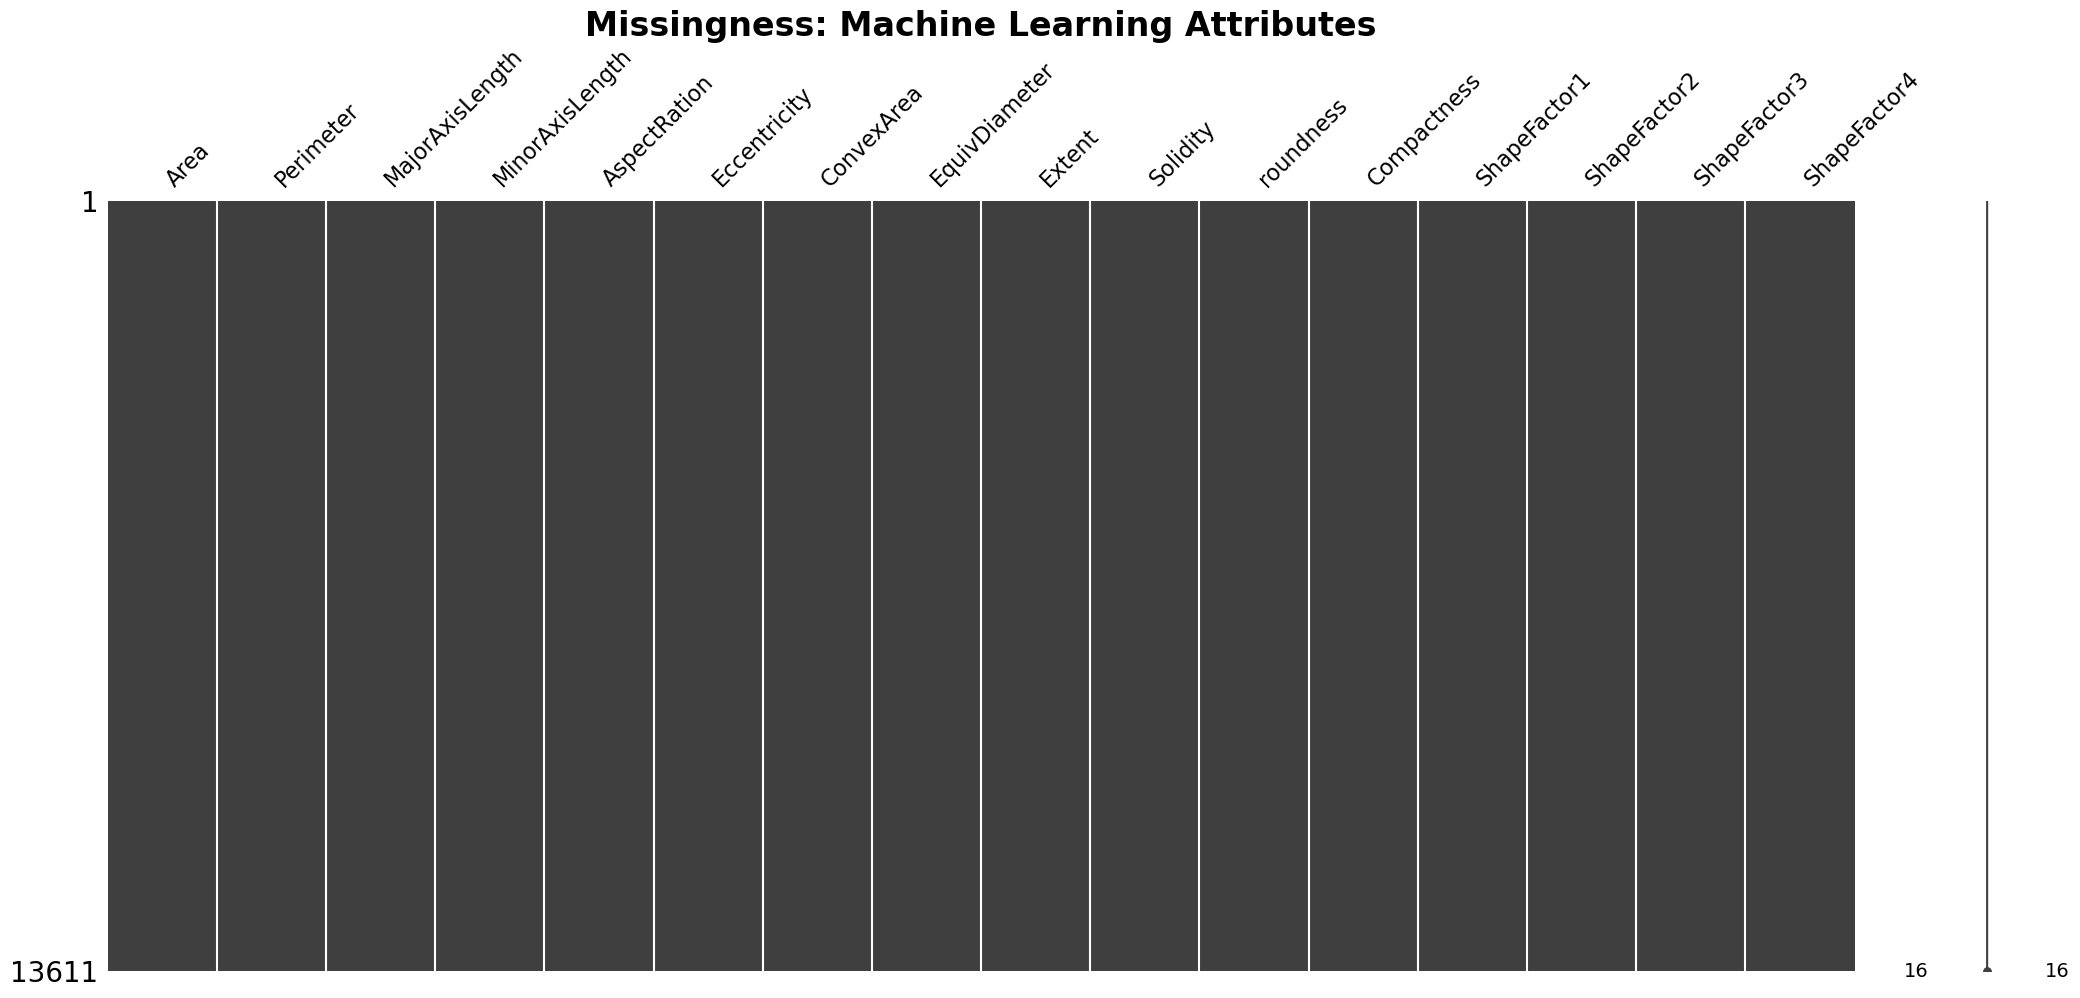

In [98]:
# display missingness plot; ml attributes
msno.matrix(design_df[numerical_cols + nominal_cols])
plt.title("Missingness: Machine Learning Attributes", weight = 'bold', fontsize = 24)

# save fig
plt.savefig(figs_path + "/missing_attributes_ml_attributes.png", bbox_inches = 'tight')

In [99]:
print('Machine Learning Attributes Datatypes:')
design_df[numerical_cols + nominal_cols].dtypes

Machine Learning Attributes Datatypes:


Area               float64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
AspectRation       float64
Eccentricity       float64
ConvexArea         float64
EquivDiameter      float64
Extent             float64
Solidity           float64
roundness          float64
Compactness        float64
ShapeFactor1       float64
ShapeFactor2       float64
ShapeFactor3       float64
ShapeFactor4       float64
dtype: object

___

## Build Transformer Pipeline

___

### Numerical Transformer: Impute & Scale

In [100]:
# instantiate sklearn pipeline
numerical_transformer = Pipeline(
    steps=[
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())
          ]
        )

### Nominal Transformer: Impute and Encode  
Determine min frequency for nominal transformer

In [101]:
if len(nominal_cols) > 0:
    print(design_df[nominal_cols].value_count())
    print('Set min_frequency for nominal transformer in perameters cell.')
else:
    min_frequency = None

In [102]:
# instantiate nominal transformer
nominal_transformer = Pipeline(
    steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot_encoder', OneHotEncoder(sparse_output=False, min_frequency=min_frequency))
    ]
)

### Column Transformer:

In [103]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_cols),
            ('nominal', nominal_transformer, nominal_cols)
        ]
)

### Execute Pipeline with Design Matrix

In [104]:
# execute pipeline
trans_df = pd.DataFrame(
    data = preprocessor.fit_transform(design_df),
    index = design_df.index, # KEEP TRACK OF INDEX
    columns = preprocessor.get_feature_names_out() #NAME COlumns
)

In [105]:
# display transfored dataframe
trans_df

,numerical__Area,numerical__Perimeter,numerical__MajorAxisLength,numerical__MinorAxisLength,numerical__AspectRation,numerical__Eccentricity,numerical__ConvexArea,numerical__EquivDiameter,numerical__Extent,numerical__Solidity,numerical__roundness,numerical__Compactness,numerical__ShapeFactor1,numerical__ShapeFactor2,numerical__ShapeFactor3,numerical__ShapeFactor4
0,-0.840749,-1.143319,-1.306598,-0.631153,-1.565053,-2.185720,-0.841451,-1.063341,0.289087,0.367613,1.423867,1.839116,0.680786,2.402173,1.925723,0.838371
1,-0.829188,-1.013924,-1.395911,-0.434445,-1.969784,-3.686040,-0.826102,-1.044217,0.697477,-0.462907,0.231054,2.495449,0.367967,3.100893,2.689702,0.771138
2,-0.807157,-1.078829,-1.252357,-0.585735,-1.514291,-2.045336,-0.808704,-1.008084,0.578195,0.518417,1.252865,1.764843,0.603129,2.235091,1.841356,0.916755
3,-0.785741,-0.977215,-1.278825,-0.439290,-1.741618,-2.742211,-0.773975,-0.973337,0.671260,-2.241767,0.515049,2.081715,0.401718,2.515075,2.204250,-0.197985
4,-0.781239,-1.097384,-1.380471,-0.266663,-2.117993,-4.535028,-0.784286,-0.966080,0.476020,0.804772,1.874992,2.765330,0.118268,3.270983,3.013462,0.939640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,-0.373471,-0.446083,-0.366669,-0.363055,-0.123703,0.153343,-0.378191,-0.364148,-0.716284,0.684173,0.727872,0.032433,0.261425,0.055630,-0.006086,0.760813
13607,-0.373334,-0.456336,-0.450053,-0.257015,-0.432979,-0.165141,-0.378662,-0.363962,1.022933,0.774384,0.818807,0.362794,0.110384,0.285117,0.328393,0.722659
13608,-0.372038,-0.447833,-0.450478,-0.246456,-0.448618,-0.182940,-0.376143,-0.362197,-0.403392,0.591370,0.758468,0.370533,0.104269,0.289204,0.336328,0.390251
13609,-0.371765,-0.427029,-0.428974,-0.266742,-0.380735,-0.106960,-0.372851,-0.361825,-0.903414,0.143717,0.581753,0.285098,0.141906,0.228375,0.248973,0.036440


___

## Check Dimensions

In [106]:
assert len(trans_df) == len(target_vector)

print("Design Matrix Shape:", trans_df.shape)
print("Target Vector Shape:", target_vector.shape)

Design Matrix Shape: (13611, 16)
Target Vector Shape: (13611, 2)


In [107]:
# relable target vector, we can go back an change this later
target_vector = target_vector.rename(columns={'id': 'ID', 'target_encoded': 'Target'})
target_vector

,ID,Target
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
...,...,...
13606,13606,3
13607,13607,3
13608,13608,3
13609,13609,3


___

## Shuffle Data Objects

### Feature Matrix

In [108]:
# Add ID columns
cols = list(trans_df.columns)
trans_df['ID'] = np.arange(0, len(trans_df))
col_order = ['ID'] + cols
design_matrix = trans_df[col_order]
design_matrix_shuffled = shuffle(design_matrix, random_state=42, n_samples=None)
design_matrix_shuffled

,ID,numerical__Area,numerical__Perimeter,numerical__MajorAxisLength,numerical__MinorAxisLength,numerical__AspectRation,numerical__Eccentricity,numerical__ConvexArea,numerical__EquivDiameter,numerical__Extent,numerical__Solidity,numerical__roundness,numerical__Compactness,numerical__ShapeFactor1,numerical__ShapeFactor2,numerical__ShapeFactor3,numerical__ShapeFactor4
1488,1488,-0.365218,-0.532278,-0.699519,0.111983,-1.330113,-1.592944,-0.372549,-0.352918,0.437396,1.064426,1.597939,1.498162,-0.370573,1.153692,1.541930,0.989265
2611,2611,0.518320,1.089549,0.586132,0.791512,-0.106143,0.169698,0.550947,0.704943,0.365695,-3.127637,-2.516723,-0.064090,-1.007778,-0.625351,-0.102226,-1.995235
749,749,-0.518101,-0.683994,-0.836862,-0.175910,-1.236665,-1.391983,-0.521807,-0.566452,-0.103759,0.648568,1.240429,1.358954,-0.000975,1.263821,1.387803,0.726306
99,99,-0.678828,-0.965544,-1.139157,-0.278714,-1.663886,-2.482813,-0.684870,-0.805076,0.412487,1.254524,1.972582,1.997703,0.133443,2.168059,2.107283,1.008149
11298,11298,-0.788571,-0.969347,-0.961919,-0.917663,-0.432975,-0.165137,-0.787511,-0.977908,0.724802,-0.043581,0.394278,0.344776,1.223497,0.858969,0.309933,0.104866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,5191,1.030512,1.224997,1.497611,0.788917,1.228794,1.054634,1.016389,1.225843,0.967838,0.807939,-0.601791,-1.196511,-1.043987,-1.330581,-1.176625,-0.170536
13418,13418,-0.449861,-0.466169,-0.426161,-0.507908,-0.010367,0.256019,-0.451343,-0.469661,-1.173051,0.242246,0.075035,-0.090740,0.489755,0.052009,-0.128644,0.485566
5390,5390,1.260297,1.406165,1.595202,1.113733,0.920507,0.898803,1.243435,1.444142,0.696877,0.901208,-0.467030,-0.953662,-1.319088,-1.295505,-0.954530,-0.235434
860,860,-0.498662,-0.671412,-0.857094,-0.082613,-1.381553,-1.711199,-0.502764,-0.538625,0.048110,0.696000,1.357839,1.567757,-0.127278,1.415513,1.619543,0.861651


### Target Vector:

In [109]:
target_vector_shuffled = shuffle(target_vector, random_state=42, n_samples=None)
target_vector_shuffled

,ID,Target
1488,1488,5
2611,2611,0
749,749,5
99,99,5
11298,11298,3
...,...,...
5191,5191,2
13418,13418,3
5390,5390,2
860,860,5


___

## Save Shuffled DataFrames to CSV

In [117]:
# save shuffled design dataframe
design_matrix_shuffled.to_csv(data_path + shuffled_design_filename, index=False)
print("design_matrix_shuffled saved at:", data_path + shuffled_design_filename)

# save shuffled tartget dataframe
target_vector_shuffled.to_csv(data_path + shuffled_target_filename, index=False)
print("target_vector_shuffled saved at:", data_path + shuffled_target_filename)


design_matrix_shuffled saved at: /Users/mikey/LocalFiles/DS5230/final_project/DS5230-final/data/curated/shuffled_design.csv
target_vector_shuffled saved at: /Users/mikey/LocalFiles/DS5230/final_project/DS5230-final/data/curated/shuffled_target.csv


___

## Convert Feature Matrix to ndarray:

In [111]:
# drop ID col
design_matrix_shuffled_noID = design_matrix_shuffled.drop('ID', axis=1)

# convert to ndarray
cap_x = design_matrix_shuffled_noID.to_numpy()
print(f'cap_x shape: {cap_x.shape}')
cap_x

cap_x shape: (13611, 16)


array([[-0.36521767, -0.5322778 , -0.69951932, ...,  1.15369168,
         1.54192977,  0.98926454],
       [ 0.51832029,  1.08954897,  0.58613222, ..., -0.6253513 ,
        -0.10222622, -1.99523524],
       [-0.51810098, -0.68399389, -0.83686158, ...,  1.2638209 ,
         1.38780271,  0.72630639],
       ...,
       [ 1.26029711,  1.40616472,  1.595202  , ..., -1.29550493,
        -0.95452972, -0.2354344 ],
       [-0.49866232, -0.67141233, -0.85709382, ...,  1.41551329,
         1.61954278,  0.86165138],
       [ 0.36079899,  0.6631759 ,  0.94108189, ..., -1.22107966,
        -1.40651082, -0.99763592]])

___

## UMAP (default params)

In [112]:
results_dict = umap_dim_red(cap_x)

___

## K-Means  (default params)

In [113]:
results_dict, kmeans_solution = kmeans(results_dict)

****************************************************************************************************
****************************************************************************************************
Hyperparameters:
n_neighbors:  15
min_dist:  0.1
metric:  euclidean
n_components:  2


/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/

Hopkin's Statistic = 0.2928444402011746
Fail: Kmeans did not successfully cluster.


___

## DBSCAN  (default params)

In [114]:
if kmeans_solution:
    results_df = pd.DataFrame(results_dict)
else:
    results_dict = dbscan(results_dict)
    results_df = pd.DataFrame(results_dict)


zero-size array to reduction operation minimum which has no identity
DBSCAN
Number of Clusters:  5
Validity Index:  -0.27959427564427325


___

# Results

In [115]:
display(results_df)

,algo,n_clusters_found,n_clusters_db_score_is_min,n_clusters_ch_score_is_max,n_clusters_silhouette_score_is_max,silhouette_score,hopkins_statistic,umap_n_neighbors,umap_min_dist,umap_metric,umap_n_components,trustworthiness,eps,dbscan_min_samples,validity_index,cluster_labels
0,dbscan,5,NaN,NaN,NaN,NaN,0.292844,15,0.1,euclidean,2,0.976459,0.260079,6,-0.279594,"[0, 1, 0, 0, 2, 0, 1, 0, 3, 2, 2, 2, 2, 1, 2, ..."


___

## Runtime

In [116]:
finish = time.time()
hours = int((finish - start) // 3600)
minutes = int(((finish - start) % 3600) // 60)
seconds = int((finish - start) % 60)
print(f"Total Run Time(hh:mm.ss): {hours:02d}:{minutes:02d}.{seconds:02d}")

Total Run Time(hh:mm.ss): 00:02.13
